Predicting Bicycle Traffic

In [1]:
#import libraries
import pandas as pd
import numpy as np

In [2]:
counts = pd.read_csv("Fremont_Bridge_Bicycle_Counter.csv", index_col="Date", parse_dates=True)
weather =pd.read_csv("3243863.csv",index_col="DATE", parse_dates= True)

In [3]:
#Review of datasets
counts.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0
2012-10-03 03:00:00,5.0,2.0,3.0
2012-10-03 04:00:00,7.0,6.0,1.0


In [4]:
weather.head()

,STATION,NAME,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,...,WT04,WT05,WT06,WT08,WT09,WT13,WT14,WT16,WT18,WT22
DATE,,,,,,,,,,,,,,,,,,,,,
2012-10-01,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",6.71,NaN,0.0,0.0,0.0,NaN,74.0,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-02,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",9.17,NaN,0.0,0.0,0.0,NaN,64.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-03,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",16.33,NaN,0.0,0.0,0.0,NaN,66.0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-04,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",14.54,NaN,0.0,0.0,0.0,NaN,66.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-05,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",12.75,NaN,0.0,0.0,0.0,NaN,71.0,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Compute the total daily bicycle traffic and put this in its own DataFrame

In [5]:
daily = counts.resample("d").sum() # grouping the data by day ("d") and sum the values for each day
daily["Total"] = daily.sum(axis=1) #creating a new column called "Total"
daily = daily[["Total"]] #modify the DF just with the new total column
daily.head()

,Total
Date,
2012-10-03,7042.0
2012-10-04,6950.0
2012-10-05,6296.0
2012-10-06,4012.0
2012-10-07,4284.0


In [6]:
days = ["Mon", "Tue", "Wed","Thu","Fri","Sat","Sun"]
for i in range(7):
    daily[days[i]] = (daily.index.day_of_week==i).astype(float)

Expect riders to behave diffrentlu on holidays, so adding and indicator

In [7]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal =USFederalHolidayCalendar()
holidays = cal.holidays("2012","2023")
daily = daily.join(pd.Series(1,index=holidays, name="holiday"))
daily["holiday"].fillna(0, inplace=True)



In [8]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Suspect that the hours of daylight would affect how many people ride

C:\Users\herre\AppData\Local\Temp\ipykernel_31676\424124005.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (date - pd.datetime(2000,12,21)).days


<AxesSubplot: xlabel='Date'>

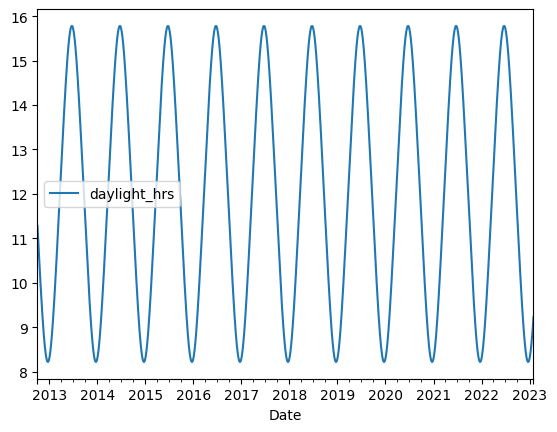

In [9]:
def hours_of_daylight(date, axis=23.44, latitude =47.61):
    """Compute the hours of daylight of the given date"""
    days = (date - pd.datetime(2000,12,21)).days
    m = (1. -np.tan(np.radians(latitude))
        * np.tan(np.radians(axis)* np.cos(days*2*np.pi /365.25)))
    return 24 * np.degrees(np.arccos(1 - np.clip(m, 0,2)))/180

daily["daylight_hrs"] = list(map(hours_of_daylight,daily.index))
daily[["daylight_hrs"]].plot()  #Visualization of hours of daylight in Seattle


Average temperature and total precipitation to the data. In addition to the inches of precipitation. I will ad a flag indicates whether a day is dry (has zero precipitation)

In [10]:
#temperatures are in 1/10 deg C, convert to Celcius
weather["TMIN"] /= 10
weather["TMAX"] /= 10
weather["Temp (C)"] = 0.5*(weather["TMIN"] + weather["TMAX"])

#Precip is in 1/10 mm convert to inches
weather ["PRCP"] /=254
weather["dry day"] = (weather["PRCP"]== 0).astype(int)

daily = daily.join(weather[["PRCP","Temp (C)", "dry day"]])

In [11]:
daily["annual"] = (daily.index - daily.index[0]).days/365

In [12]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,5.60,1,0.000000
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,5.65,1,0.002740
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,5.95,1,0.005479
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,6.05,1,0.008219
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,6.05,1,0.010959


In [13]:

daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3773 entries, 2012-10-03 to 2023-01-31
Freq: D
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Total         3773 non-null   float64
 1   Mon           3773 non-null   float64
 2   Tue           3773 non-null   float64
 3   Wed           3773 non-null   float64
 4   Thu           3773 non-null   float64
 5   Fri           3773 non-null   float64
 6   Sat           3773 non-null   float64
 7   Sun           3773 non-null   float64
 8   holiday       3773 non-null   float64
 9   daylight_hrs  3773 non-null   float64
 10  PRCP          3768 non-null   float64
 11  Temp (C)      3772 non-null   float64
 12  dry day       3773 non-null   int32  
 13  annual        3773 non-null   float64
dtypes: float64(13), int32(1)
memory usage: 556.4 KB


In [14]:
mean = daily['PRCP'].mean()

In [15]:
daily["PRCP"].fillna(mean, inplace= True)

In [16]:
mean1= daily["Temp (C)"].mean()

In [17]:
daily["Temp (C)"].fillna(mean1, inplace= True)

Now we can choose the columns to use, and fit a linear regression model to our data. We will set fit_intercept = False, because the daily flags essentially operate as their own day-specific intercepts 

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
column_names =["Mon", "Tue", "Wed","Thu","Fri","Sat","Sun", "holiday", "daylight_hrs", "PRCP", "dry day", "Temp (C)", "annual"]
X = daily[column_names]
y = daily["Total"]

model = LinearRegression(fit_intercept= False)
model.fit(X,y)
daily["predicted"] = model.predict(X)

<AxesSubplot: xlabel='Date'>

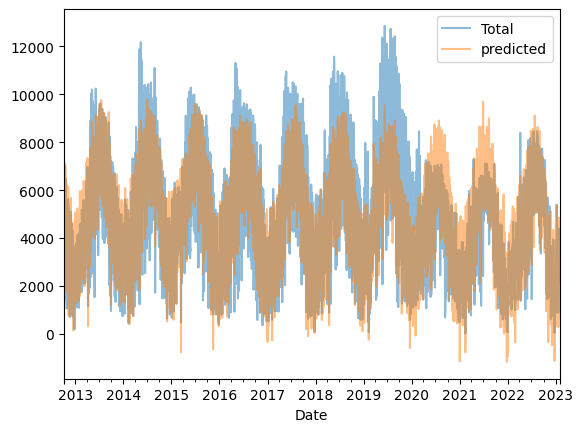

In [20]:
daily[["Total", "predicted"]].plot(alpha=0.5)